<a href="https://colab.research.google.com/github/francescomazzolin/stochastic-finance-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stochastic Finance Project

Giada Martini

Francesco Mazzolin

Francesco Salvagnin

Nicolas Stecca


## Importing the packages


In [318]:

#!pip install eikon

import eikon as ek
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
import analytical_functions as af
import importlib

importlib.reload(af)


<module 'analytical_functions' from 'c:\\Users\\paolo\\OneDrive\\Desktop\\SF_Project\\stochastic-finance-project\\analytical_functions.py'>

## Retrieving the data

In [282]:
# Setting up the API key
ek.set_app_key('6e2b6a629eb84c0b859dc5faf22d48f94d85de97')

#### Search parameters


In [283]:

fields = ['TR.CLOSEPRICE.date',
            'TR.CLOSEPRICE', 
            'TR.F.ShrUsedToCalcDilEPSTot','TR.F.MktCap', 'TR.F.DebtTot']

start_date = '2024-12-30'

end_date = '2018-12-30'

rolling_window = 252

In [284]:
#Setting up the function
def get_financial_data(rics, fields, 
                       start_date, end_date,
                       rolling_window):
    #rics = rics
    #Data fields we are interested in: 
      #Total value of equity
      #Total value of debt

    results = []

    df = pd.DataFrame()

    for ric in rics:
        data, err = ek.get_data([ric], fields,
                                {'SDate': f'{start_date}' , 'EDate': f'{end_date}', 'FRQ':'D','period':'FY0'}) #Not sure about period
        if err is None:
            data['RIC'] = ric
            results.append(data)
        else:
            print(f"Error retrieving data for {ric}: {err}")
        
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values(by='Date').reset_index(drop=True)


        #Computing the log-returns
        prices = data['Close Price']
        log_returns = np.log(prices / prices.shift(1)).dropna()
        data['Log_Returns'] = log_returns
        data.dropna()

        #Compute the rolling-window estimation of the volatility using last year observations
        data['Rolling_Volatility'] = (data['Log_Returns'].rolling(window=rolling_window).std() * np.sqrt(rolling_window) )
        data = data.dropna(subset=['Rolling_Volatility'])
        data = data.dropna(how = 'any')
        


        #Computing total asset values as a sum of the market capitalization + total debt
        #data['Total_value'] = data['Market Capitalization'] + data['Debt - Total']
        data['Total_value'] = (data['Close Price'] * data['Shares used to calculate Diluted EPS - Total']) + data['Debt - Total']
        
        
        data = data.set_index(['Instrument', 'Date'])

    #Combine results into a single DataFrame
        df = pd.concat([df, data])
    #df.drop(columns=['RIC'])

    #Add Total asset value column
    

    return df


#### Choosing the stocks

In [286]:
rics_list = ['AAPL.O', 'META.O', 'BRBI.MI']

#### Retrieving the data

In [287]:
data = get_financial_data(rics_list, fields,
                          start_date, end_date,
                          252)

c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will r

In [288]:
data

Close Price  \
Instrument Date                                     
AAPL.O     2019-12-31 00:00:00+00:00      73.4125   
           2020-01-02 00:00:00+00:00      75.0875   
           2020-01-03 00:00:00+00:00      74.3575   
           2020-01-06 00:00:00+00:00        74.95   
           2020-01-07 00:00:00+00:00      74.5975   
...                                           ...   
BRBI.MI    2024-12-19 00:00:00+00:00        8.957   
           2024-12-20 00:00:00+00:00         8.99   
           2024-12-23 00:00:00+00:00        8.984   
           2024-12-27 00:00:00+00:00        9.126   
           2024-12-30 00:00:00+00:00        9.093   

                                      Shares used to calculate Diluted EPS - Total  \
Instrument Date                                                                      
AAPL.O     2019-12-31 00:00:00+00:00                                   18595652000   
           2020-01-02 00:00:00+00:00                                   18595652000   
           2020-01-03 00:00:00+00:00                                   18595652000   
           2020-01-06 00:00:00+00:00                                   18595652000   
           2020-01-07 00:00:00+00:00                                   18595652000   
...                                                                            ...   
BRBI.MI    2024-12-19 00:00:00+00:00                                     323640100   
           2024-12-20 00:00:00+00:00                                     323640100   
           2024-12-23 00:00:00+00:00                                     323640100   
           2024-12-27 00:00:00+00:00                                     323640100   
           2024-12-30 00:00:00+00:00                                     323640100   

                                      Market Capitalization    Debt - Total  \
Instrument Date                                                               
AAPL.O     2019-12-31 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-02 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-03 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-06 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-07 00:00:00+00:00         988886967600.0  108047000000.0   
...                                                     ...             ...   
BRBI.MI    2024-12-19 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-20 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-23 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-27 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-30 00:00:00+00:00           3706536975.0     931124000.0   

                                          RIC  Log_Returns  \
Instrument Date                                              
AAPL.O     2019-12-31 00:00:00+00:00   AAPL.O      0.00728   
           2020-01-02 00:00:00+00:00   AAPL.O      0.02256   
           2020-01-03 00:00:00+00:00   AAPL.O     -0.00977   
           2020-01-06 00:00:00+00:00   AAPL.O     0.007937   
           2020-01-07 00:00:00+00:00   AAPL.O    -0.004714   
...                                       ...          ...   
BRBI.MI    2024-12-19 00:00:00+00:00  BRBI.MI    -0.016828   
           2024-12-20 00:00:00+00:00  BRBI.MI     0.003677   
           2024-12-23 00:00:00+00:00  BRBI.MI    -0.000668   
           2024-12-27 00:00:00+00:00  BRBI.MI     0.015682   
           2024-12-30 00:00:00+00:00  BRBI.MI    -0.003623   

                                      Rolling_Volatility      Total_value  
Instrument Date                                                            
AAPL.O     2019-12-31 00:00:00+00:00            0.263392  1473200302450.0  
           2020-01-02 00:00:00+00:00            0.264154  1504348019550.0  
           2020-01-03 00:00:00+00:00            0.241447  1490773193590.0  
           202

In [289]:
# import pickle
# import sys
# import os

# current_directory = os.getcwd()

# # Add the current working directory to sys.path
# if current_directory not in sys.path:
#     sys.path.append(current_directory)
#     print('Yes')


# with open('dataframe.pkl', mode= 'rb') as f:

#     data = pickle.load(f)

In [290]:
#Checks on single stocks
print(data.loc['AAPL.O'].head())

                           Close Price  \
Date                                     
2019-12-31 00:00:00+00:00      73.4125   
2020-01-02 00:00:00+00:00      75.0875   
2020-01-03 00:00:00+00:00      74.3575   
2020-01-06 00:00:00+00:00        74.95   
2020-01-07 00:00:00+00:00      74.5975   

                           Shares used to calculate Diluted EPS - Total  \
Date                                                                      
2019-12-31 00:00:00+00:00                                   18595652000   
2020-01-02 00:00:00+00:00                                   18595652000   
2020-01-03 00:00:00+00:00                                   18595652000   
2020-01-06 00:00:00+00:00                                   18595652000   
2020-01-07 00:00:00+00:00                                   18595652000   

                           Market Capitalization    Debt - Total     RIC  \
Date                                                                       
2019-12-31 00:00:00+00:00  

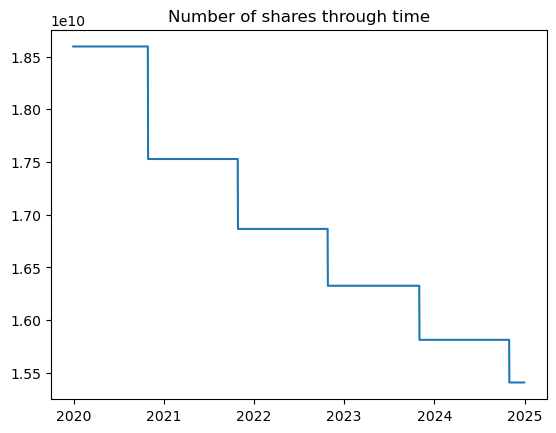

In [291]:
#Plot of outstanding shares 
import matplotlib.pyplot as plt

plt.figure()

plt.title('Number of shares through time')

plt.plot(data.loc['AAPL.O']['Shares used to calculate Diluted EPS - Total'])

plt.show()


## Computing the value of the asset and its volatility

In [292]:
# df_k = pd.DataFrame()

# for ric in rics_list:
#     df = data.loc[ric]
#     df = df.reset_index()
#     df['Total_value'] = (df['Close Price'] * df['Shares used to calculate Diluted EPS - Total']) +df['Debt - Total']
#     # Compute log returns and rolling volatility
#     df['Log_Returns'] = np.log(df['Close Price'] / df['Close Price'].shift(1))
#     df['Rolling_Volatility'] = df['Log_Returns'].rolling(window=252).std() 
#     df = df.dropna(subset=['Rolling_Volatility'])
    
#     # Compute total asset value (equity + debt)
#     #df['Total_value'] = df['Market Capitalization'] + df['Debt - Total']
#     df['RIC'] = ric
#     df = df.set_index([f'RIC', 'Date'])
#     df = df.dropna(how='any')

#     # Drop rows with missing data
    

#     df_k = pd.concat([df, df_k])

# data = df_k.copy()

In [293]:
data.loc[rics_list[1]].describe()

,Close Price,Shares used to calculate Diluted EPS - Total,Market Capitalization,Debt - Total,Log_Returns,Rolling_Volatility,Total_value
count,1258.0,1258.0,1258.0,1258.0,1258.0,1258.000000,1258.0
mean,301.120862,2795876788.553259,696629297912.21936,5921100158.982512,0.000844,0.435858,839043537412.55957
std,124.791399,104409770.047277,232457747031.115479,7357691236.093029,0.028596,0.110142,324285780110.595276
min,88.91,2629000000.0,315555188424.080017,0.0,-0.306391,0.254210,254774690000.0
25%,209.5925,2702000000.0,585320975487.75,523000000.0,-0.011683,0.354419,594188022500.0
50%,280.825,2859000000.0,778039626010.359985,581000000.0,0.001067,0.405224,795625770000.0
75%,346.275,2876000000.0,909628612618.719971,10610000000.0,0.014418,0.527885,990168400000.0
max,632.68,2921000000.0,935644813206.599976,19075000000.0,0.209307,0.705082,1682390719999.999756


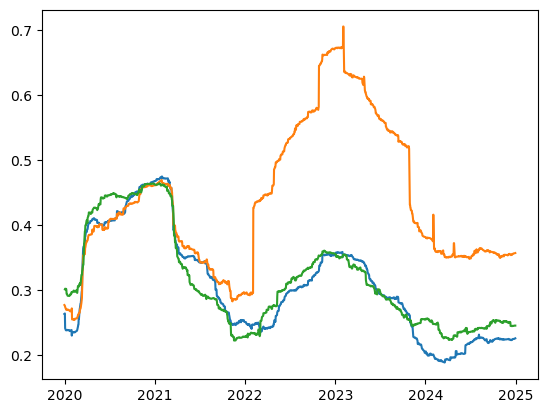

In [294]:
for ric in rics_list:

    plt.plot(data.loc[ric]['Rolling_Volatility'])

In [295]:
# Solve the system for each row
def solve_system(row):
    # Extract parameters from the row
    E = row['Close Price'] * row['Shares used to calculate Diluted EPS - Total'] # Equity (market capitalization)
    sigma_E = row['Rolling_Volatility']  # Rolling volatility as initial guess for sigma_A
    D = row['Debt - Total']          # Debt
    
    row['Risk_Free_Rate'] = 0.04
    r = row['Risk_Free_Rate']        # Assume a risk-free rate column
    
    T = 1                            # Time to maturity (1 year)
    t = 0                            # Current time

    # Define the system of equations
    def system(vars):
        if D > 0:
            A, sigma_A = vars  # Unknowns: Asset value and asset volatility
            equity_value = af.merton_equity(A, D, r, sigma_A, T, t)
            d1 = (np.log(A / D) + (r + 0.5 * sigma_A**2) * (T - t)) / (sigma_A * np.sqrt(T - t))
            f1 = equity_value - E  # Equation (2)
            f2 = (A / E) * norm.cdf(d1) * sigma_A - sigma_E  # Equation (4)

        else: 

            f1 = E 
            f2 = sigma_E
        return [f1, f2]

    # Initial guesses
    A_guess = row['Total_value']  # Total value (equity + debt)
    sigma_A_guess = row['Rolling_Volatility']  # Rolling volatility

    # Solve the system
    solution = fsolve(system, [A_guess, sigma_A_guess])
    return pd.Series({'A_solution': solution[0], 'sigma_A_solution': solution[1]})

# Apply the solver to the DataFrame
def solve_for_all(df):
    results = df.apply(solve_system, axis=1)
    return pd.concat([df, results], axis=1)


In [296]:
data.isna().sum()

Close Price                                     0
Shares used to calculate Diluted EPS - Total    0
Market Capitalization                           0
Debt - Total                                    0
RIC                                             0
Log_Returns                                     0
Rolling_Volatility                              0
Total_value                                     0
dtype: int64

In [297]:
df_with_solutions = solve_for_all(data)

c:\Users\paolo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\paolo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\paolo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\paolo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\paolo\anaconda3\Lib\site-packages\scipy

In [298]:
df_with_solutions

Close Price  \
Instrument Date                                     
AAPL.O     2019-12-31 00:00:00+00:00      73.4125   
           2020-01-02 00:00:00+00:00      75.0875   
           2020-01-03 00:00:00+00:00      74.3575   
           2020-01-06 00:00:00+00:00        74.95   
           2020-01-07 00:00:00+00:00      74.5975   
...                                           ...   
BRBI.MI    2024-12-19 00:00:00+00:00        8.957   
           2024-12-20 00:00:00+00:00         8.99   
           2024-12-23 00:00:00+00:00        8.984   
           2024-12-27 00:00:00+00:00        9.126   
           2024-12-30 00:00:00+00:00        9.093   

                                      Shares used to calculate Diluted EPS - Total  \
Instrument Date                                                                      
AAPL.O     2019-12-31 00:00:00+00:00                                   18595652000   
           2020-01-02 00:00:00+00:00                                   18595652000   
           2020-01-03 00:00:00+00:00                                   18595652000   
           2020-01-06 00:00:00+00:00                                   18595652000   
           2020-01-07 00:00:00+00:00                                   18595652000   
...                                                                            ...   
BRBI.MI    2024-12-19 00:00:00+00:00                                     323640100   
           2024-12-20 00:00:00+00:00                                     323640100   
           2024-12-23 00:00:00+00:00                                     323640100   
           2024-12-27 00:00:00+00:00                                     323640100   
           2024-12-30 00:00:00+00:00                                     323640100   

                                      Market Capitalization    Debt - Total  \
Instrument Date                                                               
AAPL.O     2019-12-31 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-02 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-03 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-06 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-07 00:00:00+00:00         988886967600.0  108047000000.0   
...                                                     ...             ...   
BRBI.MI    2024-12-19 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-20 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-23 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-27 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-30 00:00:00+00:00           3706536975.0     931124000.0   

                                          RIC  Log_Returns  \
Instrument Date                                              
AAPL.O     2019-12-31 00:00:00+00:00   AAPL.O      0.00728   
           2020-01-02 00:00:00+00:00   AAPL.O      0.02256   
           2020-01-03 00:00:00+00:00   AAPL.O     -0.00977   
           2020-01-06 00:00:00+00:00   AAPL.O     0.007937   
           2020-01-07 00:00:00+00:00   AAPL.O    -0.004714   
...                                       ...          ...   
BRBI.MI    2024-12-19 00:00:00+00:00  BRBI.MI    -0.016828   
           2024-12-20 00:00:00+00:00  BRBI.MI     0.003677   
           2024-12-23 00:00:00+00:00  BRBI.MI    -0.000668   
           2024-12-27 00:00:00+00:00  BRBI.MI     0.015682   
           2024-12-30 00:00:00+00:00  BRBI.MI    -0.003623   

                                      Rolling_Volatility      Total_value  \
Instrument Date                                                             
AAPL.O     2019-12-31 00:00:00+00:00            0.263392  1473200302450.0   
           2020-01-02 00:00:00+00:00            0.264154  1504348019550.0   
           2020-01-03 00:00:00+00:00            0.241447  1490773193590.0   
         

In [299]:
x = df_with_solutions['Close Price'] * df_with_solutions['Shares used to calculate Diluted EPS - Total']

asset_value = df_with_solutions['A_solution']

result = asset_value - x
result.describe()

count                 3790.0
mean      39153045280.647095
std       51269994354.154114
min                      0.0
25%         626263543.759302
50%         933859471.475763
75%      107716025602.245117
max      120643447506.040039
dtype: Float64

## Computing the relevant quantities of the Merton's model

In [319]:
def compute_additional_metrics(row):
    # Extract inputs from the row
    """
    V = row['Total_value']  # Asset value
    sigma = row['Rolling_Volatility']  # Asset volatility
    """
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    
    K = row['Debt - Total']  # Debt
    row['Risk_Free_Rate'] = 0.04
    r = row['Risk_Free_Rate']
    
    #print(V/K)

    T = 1  # Time to maturity
    t = 0  # Current time

    # Compute quantities using the provided functions
    equity_value = af.merton_equity(V, K, r, sigma, T, t)
    debt_value = af.merton_debt(V, K, r, sigma, T, t)
    default_probability = af.default_probability(V, K, r, sigma, T, t)
    credit_spread = af.credit_spread_model(V, K, sigma, r, T, t)

    # Return results as a Series
    return pd.Series({
        'Merton_Equity_Value': equity_value,
        'Merton_Debt_Value': debt_value,
        'Default_Probability': default_probability,
        'Credit_Spread': credit_spread
    })

In [320]:
# Compute additional metrics for each row
df_with_metrics = df_with_solutions.apply(compute_additional_metrics, axis=1)

# Combine results with the original DataFrame
df_final = pd.concat([df_with_solutions, df_with_metrics], axis=1)

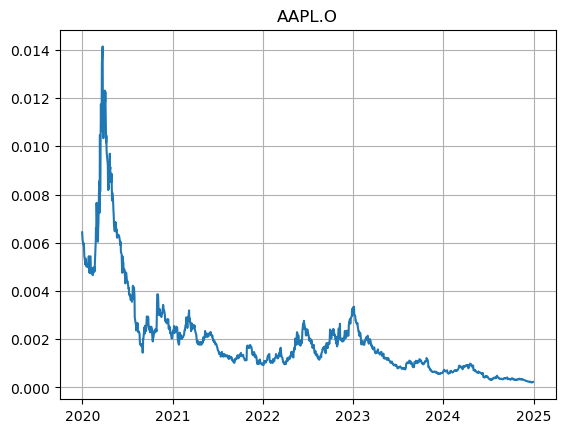

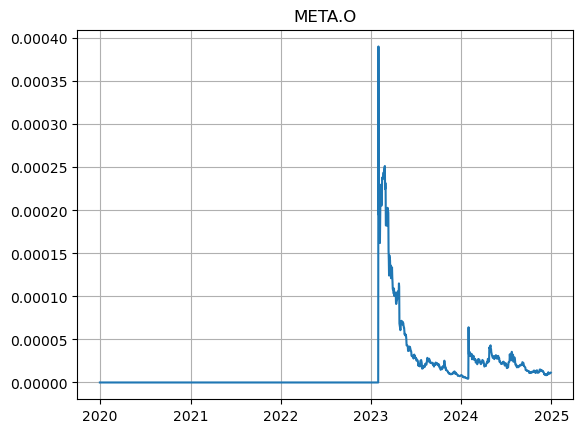

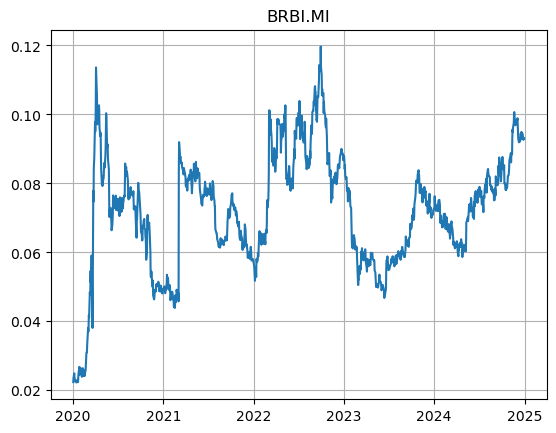

In [321]:
import matplotlib.pyplot as plt
for ric in rics_list:
    plt.figure()

    def_probab = df_final.loc[ric]['Default_Probability']
    plt.plot(def_probab)
    plt.title(f'{ric}')

    plt.grid()

    plt.show()

In [324]:
df_final.loc[rics_list[2]].tail()

,Close Price,Shares used to calculate Diluted EPS - Total,Market Capitalization,Debt - Total,RIC,Log_Returns,Rolling_Volatility,Total_value,A_solution,sigma_A_solution,Merton_Equity_Value,Merton_Debt_Value,Default_Probability,Credit_Spread
Date,,,,,,,,,,,,,,
2024-12-19 00:00:00+00:00,8.957,323640100,3706536975.0,931124000.0,BRBI.MI,-0.016828,0.245158,3829968375.7,3.793458e+09,0.187347,2.898844e+09,8.946141e+08,0.094934,2.220446e-16
2024-12-20 00:00:00+00:00,8.99,323640100,3706536975.0,931124000.0,BRBI.MI,0.003677,0.245199,3840648499.0,3.804139e+09,0.187541,2.909524e+09,8.946141e+08,0.094477,4.440892e-16
2024-12-23 00:00:00+00:00,8.984,323640100,3706536975.0,931124000.0,BRBI.MI,-0.000668,0.244963,3838706658.4,3.802197e+09,0.187331,2.907583e+09,8.946141e+08,0.094545,2.220446e-16
2024-12-27 00:00:00+00:00,9.126,323640100,3706536975.0,931124000.0,BRBI.MI,0.015682,0.245513,3884663552.6,3.848154e+09,0.188441,2.953540e+09,8.946141e+08,0.092629,2.220446e-16
2024-12-30 00:00:00+00:00,9.093,323640100,3706536975.0,931124000.0,BRBI.MI,-0.003623,0.245485,3873983429.3,3.837474e+09,0.188261,2.942859e+09,8.946141e+08,0.093076,2.220446e-16


In [304]:
print(df_final.loc[rics_list[0]]['Default_Probability'].describe())

count    1.258000e+03
mean     3.210926e-11
std      1.135105e-10
min      2.096195e-66
25%      4.486100e-38
50%      4.645442e-25
75%      2.738605e-17
max      1.106614e-09
Name: Default_Probability, dtype: float64


### Preparing the functions for the iterative procedure to compute asset values

In [305]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import root_scalar

def black_scholes_equation(V_t, S_t, B, r, T = 1, sigma_V = 0.1):
    """
    Compute the Black-Scholes equity price difference for an array of S_t, B, and r.
    This function is used to find the root for V_t.
    
    Parameters:
    V_t : float
        Asset value to solve for (scalar).
    S_t, B, r : np.array
        Arrays of equity prices, debt face values, and risk-free rates.
    T, sigma_V : float
        Constants: time to maturity and asset volatility.
    t : float
        Current time.

    Returns:
    np.array
        Difference between the calculated equity price and observed equity price S_t.
    """
    # Calculate d_t1 and d_t2 for all elements in S_t, B, and r
    
    d_t1 = (np.log(V_t / B) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    d_t2 = d_t1 - sigma_V * np.sqrt(T)
    
    # Black-Scholes formula for equity price
    equity_price = V_t * norm.cdf(d_t1) - B * np.exp(-r * T) * norm.cdf(d_t2)
    
    # Return the difference from observed S_t
    return equity_price - S_t

def invert_black_scholes(S_t, B, r, T=1, sigma_V = 0.1, initial_guess=100):
    """
    Invert the Black-Scholes formula to estimate V_t for arrays of S_t, B, and r.
    
    Parameters:
    S_t, B, r : np.array
        Arrays of observed equity prices, debt face values, and risk-free rates.
    T, sigma_V : float
        Constants: time to maturity and asset volatility.
    t : float
        Current time.
    initial_guess : float
        Initial guess for V_t.

    Returns:
    np.array
        Estimated asset values (V_t) for each input set.
    """
    # Vectorized root finding for each element in S_t, B, and r
    V_t_estimates = []
    for S_t_i, B_i, r_i in zip(S_t, B, r):
        # Initial bracket
        a, b = 1, 400
        f_a = black_scholes_equation(a, S_t_i, B_i, r_i, T, sigma_V)
        f_b = black_scholes_equation(b, S_t_i, B_i, r_i, T, sigma_V)
        
        # Dynamically adjust the bracket until signs are opposite
        while f_a * f_b > 0:
            a /= 2
            b *= 2
            f_a = black_scholes_equation(a, S_t_i, B_i, r_i, T, sigma_V)
            f_b = black_scholes_equation(b, S_t_i, B_i, r_i, T, sigma_V)
        
        # Solve for V_t using root_scalar
        solution = root_scalar(
            black_scholes_equation,
            args=(S_t_i, B_i, r_i, T, sigma_V),
            bracket=[a, b],
            method='brentq'
        )
        V_t_estimates.append(solution.root)
    
    return np.array(V_t_estimates)
"""
# Example Usage
S_t = np.array([50e8, 60e8, 70e8])  # Observed equity prices
B = np.array([100e6, 120e6, 150e6])  # Face values of debt
r = np.array([0.05, 0.04, 0.03])  # Risk-free rates
T = 1.0  # Maturity in years (constant)
t = 0     # Current time
sigma_V = 0.2  # Asset volatility (constant)

V_t_estimated = invert_black_scholes(S_t, B, r, T, sigma_V)
print(f"Estimated Asset Values (V_t): {V_t_estimated}")
"""

'\n# Example Usage\nS_t = np.array([50e8, 60e8, 70e8])  # Observed equity prices\nB = np.array([100e6, 120e6, 150e6])  # Face values of debt\nr = np.array([0.05, 0.04, 0.03])  # Risk-free rates\nT = 1.0  # Maturity in years (constant)\nt = 0     # Current time\nsigma_V = 0.2  # Asset volatility (constant)\n\nV_t_estimated = invert_black_scholes(S_t, B, r, T, sigma_V)\nprint(f"Estimated Asset Values (V_t): {V_t_estimated}")\n'

In [306]:
instrument = 'AAPL.O'

prices = data.loc[instrument]['Close Price']
debt = data.loc[instrument]['Debt - Total'] / 10e9
r = [0.03] * prices.shape[0] 
r = np.array(r)
log_returns = np.log(prices / prices.shift(1)).dropna()
volatility_guess = log_returns.std()

#print(volatility_guess)
#print(prices)
equity_values = (data.loc[instrument]['Shares used to calculate Diluted EPS - Total'] * data.loc[instrument]['Close Price']) / 10e9

value_guess = invert_black_scholes(equity_values, debt, r, sigma_V=volatility_guess)
print(value_guess * 10e9)

[1.47000703e+12 1.50115475e+12 1.48757992e+12 ... 4.09535192e+12
 4.04250216e+12 3.99026871e+12]


In [307]:
equity_values

Date
2019-12-31 00:00:00+00:00     136.51533
2020-01-02 00:00:00+00:00    139.630102
2020-01-03 00:00:00+00:00    138.272619
2020-01-06 00:00:00+00:00    139.374412
2020-01-07 00:00:00+00:00    138.718915
                                ...    
2024-12-23 00:00:00+00:00    393.322441
2024-12-24 00:00:00+00:00    397.837013
2024-12-26 00:00:00+00:00    399.100477
2024-12-27 00:00:00+00:00      393.8155
2024-12-30 00:00:00+00:00    388.592156
Length: 1258, dtype: Float64

# Function calling

In [308]:
"""
V = Total company value
K = Liability (strike price)
r = interest rate
sigma = standard deviation
T = Maturity
t = time (a volte non è nemmeno messo ho visto in alcune formule ma nel nostro libro c'è)


V = St+Bt

ST può essere vista come una call option ST = (VT-BT)+
BT come una Put option in pratica BT = B - (B-VT)+

"""

"""'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
FUNCTION TO COMPUTE THE EQUITY VALUE BASED ON MERTON
"""''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def merton_equity(V,K,r,sigma,T,t):

    d1 = (np.log(V/K) + (r + 0.5*sigma**2)*(T-t))/ (sigma * np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    St = V*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)

    return St

"""'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
FUNCTION TO COMPUTE THE DEBT VALUE BASED ON MERTON
"""''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def merton_debt(V,K,r,sigma,T,t):

    d1 = (np.log(V/K) + (r + 0.5*sigma**2)*(T-t))/ (sigma * np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    Bt = K*np.exp(-r*(T-t))*norm.cdf(d2) + V*(1-norm.cdf(d1))
    
    return Bt
#%% Inputs
r = 0.1        # Risk-free rate (10%)
sigma = 0.2    # Asset volatility (10%)
T = 1          # Maturity time (1 year)
t = 0          # Current time (0 years)

# Compute Equity and Debt
#equity_value = merton_equity(V, K, r, sigma, T, t)
#debt_value = merton_debt(V, K, r, sigma, T, t)

# Validation: Sum of Equity and Debt should equal Total Assets
#validation = equity_value + debt_value

# Output Results
#print(f"Equity Value (S) is: {equity_value:.6f}")
#print(f"Debt Value (B) is: {debt_value:.6f}")
#print(f"Difference between (S+B) and V: {validation:.6f} vs {V}")
#%%
data['Equity'] = data.apply(lambda row: merton_equity(row['Common Equity - Total'], row['Debt - Total'], r, sigma, T, t), axis=1)
data['Debt'] = data.apply(lambda row: merton_debt(row['Common Equity - Total'], row['Debt - Total'], r, sigma, T, t), axis=1)

KeyError: 'Common Equity - Total'